In [62]:
import datetime
from math import trunc
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pytz
import suncalc

In [63]:
LAT = 42.352  # deg
LON = 13.395  # deg
TIMEZONE = pytz.timezone("Europe/Rome")

WALL_AZIMUTH = (
    -53  # deg, south->west (0 - S, 45 - SW, 90 - W, 135 - NW, 180 - N, 270 - E, etc)
)
WALL_ALTITUDE = 0  # deg as altitude angle; 0 = vertical wall

GNOMON_LEN = 0.15  # meters
DIAL_WIDTH = 0.210 # meters
DIAL_HEIGHT = 0.297  # meters

LABEL = "Facade A4 (test)"

In [64]:
def fmt_angle(angle: float, without_sign: bool = False) -> str:
    sign = "" if angle >= 0 else "-"
    angle = abs(angle)
    degrees = trunc(angle)
    minutes = trunc((angle - degrees) * 60)
    seconds = trunc((angle - degrees - minutes / 60) * 3600)
    res_parts = [f"{degrees}°"]
    if minutes > 0:
        res_parts.append(f"{minutes}′")
    if seconds > 0:
        res_parts.append(f"{seconds}″")
    res = " ".join(res_parts)
    if without_sign:
        return res
    else:
        return sign + res


def fmt_lat(lat: float) -> str:
    return fmt_angle(lat, without_sign=True) + " " + "N" if lat > 0 else "S"


def fmt_lon(lon: float) -> str:
    return fmt_angle(lon, without_sign=True) + " " + "E" if lon > 0 else "W"


print(fmt_lat(LAT))
print(fmt_lon(LON))

42° 21′ 7″ N
13° 23′ 41″ E


In [65]:
class SunPosition(TypedDict):
    azimuth: float
    altitude: float


def calculate_sun_positions(
    date: datetime.date, step_hrs: float = 1.0, include_below_horizon: bool = False
) -> list[tuple[datetime.timedelta, SunPosition]]:
    hour_offsets = [
        datetime.timedelta(hours=h) for h in np.arange(stop=24, step=step_hrs)
    ]
    midnight = TIMEZONE.localize(
        datetime.datetime.combine(
            date,
            datetime.time(hour=0),
        )
    ).astimezone(pytz.UTC)
    positions = [
        (
            ho,
            suncalc.get_position(date=midnight + ho, lng=LON, lat=LAT),
        )
        for ho in hour_offsets
    ]
    return [(t, p) for t, p in positions if include_below_horizon or p["altitude"] > 0]

In [66]:
for t, pos in calculate_sun_positions(datetime.date.today()):
    print(
        f"{t.total_seconds() / 3600: <5.0f} az {fmt_angle(pos['azimuth'] * 180 / np.pi): <13} alt {fmt_angle(pos['altitude'] * 180 / np.pi)}"
    )

8     az -53° 16′ 15″  alt 6° 39′ 43″
9     az -41° 42′ 29″  alt 14° 49′ 37″
10    az -28° 37′ 1″   alt 21° 12′ 36″
11    az -14° 2′ 26″   alt 25° 14′ 33″
12    az 1° 26′ 34″    alt 26° 27′ 16″
13    az 16° 49′ 22″   alt 24° 40′ 58″
14    az 31° 8′ 30″    alt 20° 9′ 44″
15    az 43° 55′ 39″   alt 13° 23′ 50″
16    az 55° 13′ 13″   alt 4° 57′ 15″


In [67]:
wall_zenith = np.pi / 2 - WALL_ALTITUDE * np.pi / 180
# S->W azimuth needs to be inverted to S->E
wall_az = - WALL_AZIMUTH * np.pi / 180
wall_norm_vec = np.array(
    [
        np.cos(wall_az) * np.sin(wall_zenith),
        np.sin(wall_az) * np.sin(wall_zenith),
        np.cos(wall_zenith),
    ]
)
gnomon = wall_norm_vec * GNOMON_LEN

# local coordinate system centered at the gnomon base and with Oy going up the dial
dial_Ox = np.array(
    [np.cos(np.pi / 2 + wall_az), np.sin(np.pi / 2 + wall_az), 0.0]
)
dial_Oy = np.array(
    [
        np.cos(np.pi + wall_az) * np.sin(np.pi / 2 - wall_zenith),
        np.sin(np.pi + wall_az) * np.sin(np.pi / 2 - wall_zenith),
        np.cos(np.pi / 2 - wall_zenith),
    ]
)

In [68]:
def project_on_wall(pos: SunPosition) -> tuple[float, float] | None:
    sun_az = - pos["azimuth"]  # S->W azimuth returned by suncalc needs to be inverted to S->E
    sun_zenith = np.pi / 2 - pos["altitude"]
    to_sun_vec = np.array(
        [
            np.cos(sun_az) * np.sin(sun_zenith),
            np.sin(sun_az) * np.sin(sun_zenith),
            np.cos(sun_zenith),
        ]
    )
    from_sun_vec = -to_sun_vec

    t = - np.dot(gnomon, wall_norm_vec) / np.dot(from_sun_vec, wall_norm_vec)
    if t < 0:
        return None
    proj = gnomon + from_sun_vec * t
    return np.dot(dial_Ox, proj), np.dot(dial_Oy, proj)

In [69]:
month_middays = [
    datetime.date(year=2024, month=month, day=15) for month in range(1, 13)
]

In [70]:
pts_y = []
pts_x = []
for d in month_middays:
    for hour, sunpos in calculate_sun_positions(date=d):
        proj = project_on_wall(sunpos)
        if proj is None:
            continue
        if (
            np.abs(proj[0]) > DIAL_WIDTH or np.abs(proj[1]) > DIAL_HEIGHT
        ):  # gnomon must be above the dial
            continue
        pts_x.append(proj[0])
        pts_y.append(proj[1])

pts = np.array([pts_x, pts_y]).T

In [71]:
center_scangrid_x = np.linspace(-DIAL_WIDTH / 2, DIAL_WIDTH / 2, num=100)
center_scangrid_y = np.linspace(-DIAL_HEIGHT / 2, DIAL_HEIGHT / 2, num=100)

dial_halfsize = np.array([DIAL_WIDTH / 2, DIAL_HEIGHT / 2])

best_n_pts = 0
best_center = None
for center_x in center_scangrid_x:
    for center_y in center_scangrid_y:
        center = np.array([center_x, center_y])
        n_pts = np.sum(np.max(np.abs(pts - center) / dial_halfsize, axis=1) < 1)
        if n_pts > best_n_pts:
            best_n_pts = n_pts
            best_center = center

pts_in_dial_mask = np.max(np.abs(pts - best_center) / dial_halfsize, axis=1) < 1
pts_in_dial = pts[pts_in_dial_mask, :]
xmin = min(np.min(pts_in_dial[:, 0]), 0)
xmax = max(np.max(pts_in_dial[:, 0]), 0)
ymin = min(np.min(pts_in_dial[:, 1]), 0)
ymax = max(np.max(pts_in_dial[:, 1]), 0)
dial_center = np.array([(xmin + xmax) / 2, (ymin + ymax) / 2])

In [72]:
def is_in_dial(proj: tuple[float, float]) -> bool:
    return np.max(np.abs(np.array(proj) - dial_center) / dial_halfsize) < 1

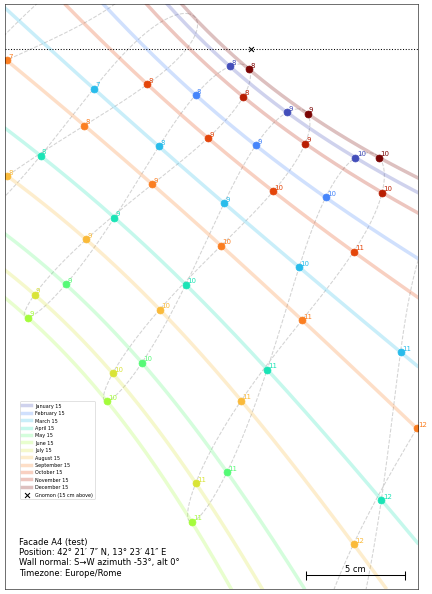

In [73]:
inch_per_meter = 1000 / 25.4
fig = plt.figure(
    figsize=(DIAL_WIDTH * inch_per_meter, DIAL_HEIGHT * inch_per_meter),
    dpi=50,
    layout="none",
    frameon=False,
)
ax = fig.add_axes((0, 0, 1, 1), xmargin=0, ymargin=0)
# ax.set_aspect("equal")


# noon and other hour mark lines
for hr in range(24):
    jan_1_ordinal = datetime.date(2024, 1, 1).toordinal()
    hour_positions = [
        suncalc.get_position(
            # hour loops are plotted according to UTC times to avoid DST shifts
            date=pytz.UTC.localize(
                datetime.datetime.combine(
                    date=datetime.date.fromordinal(jan_1_ordinal + day_of_the_year),
                    time=datetime.time(hr, 0, 0),
                )
            ),
            lng=LON,
            lat=LAT,
        )
        for day_of_the_year in range(366)
    ]
    noon_proj = [project_on_wall(pos) for pos in hour_positions]
    noon_proj = [p for p in noon_proj if p is not None]
    ax.plot(
        [x for x, _ in noon_proj],
        [y for _, y in noon_proj],
        linestyle="--",
        color="lightgray",
    )

# day lines for a middle of every month
cmap = plt.colormaps["turbo"]
for d in month_middays:
    color = cmap(d.month / 12)

    fine_proj = [
        project_on_wall(pos)
        for _, pos in calculate_sun_positions(
            date=d, step_hrs=0.01, include_below_horizon=True
        )
    ]
    fine_proj = [p for p in fine_proj if p is not None and is_in_dial(p)]
    ax.plot(
        [x for x, _ in fine_proj],
        [y for _, y in fine_proj],
        label=f"{d.strftime('%B %-d')}",
        color=color,
        linewidth=5,
        alpha=0.25,
    )

    hours = []
    hours_proj_y = []
    hours_proj_x = []
    for hour, sunpos in calculate_sun_positions(date=d):
        proj = project_on_wall(sunpos)
        if proj is None:
            continue
        if not is_in_dial(proj):
            continue
        hours.append(str(int(hour.total_seconds() / 3600)))
        hours_proj_x.append(proj[0])
        hours_proj_y.append(proj[1])
    ax.plot(hours_proj_x, hours_proj_y, ".", color=color, markersize=20)
    for x, y, hour_txt in zip(hours_proj_x, hours_proj_y, hours):
        ax.text(x + DIAL_WIDTH / 300, y + DIAL_HEIGHT / 300, hour_txt, color=color)

ax.scatter(
    [0],
    [0],
    marker="x",
    s=50,
    color="black",
    label=f"Gnomon ({100 * GNOMON_LEN:.0f} cm above)",
)
ax.axhline(0, color="k", linestyle=":")
xmin = dial_center[0] - DIAL_WIDTH / 2
xmax = dial_center[0] + DIAL_WIDTH / 2
ymin = dial_center[1] - DIAL_HEIGHT / 2
ymax = dial_center[1] + DIAL_HEIGHT / 2

scale = round(20 * DIAL_WIDTH / 5) / 20
margin_b = DIAL_WIDTH / 30
margin_x = DIAL_WIDTH / 30
ax.errorbar(
    [
        dial_center[0] + DIAL_WIDTH / 2 - scale - margin_x,
        dial_center[0] + DIAL_WIDTH / 2 - margin_x,
    ],
    [ymin + margin_b, ymin + margin_b],
    yerr=margin_b / 3,
    color="k",
)
ax.text(
    dial_center[0] + DIAL_WIDTH / 2 - scale / 2 - margin_x,
    ymin + margin_b + margin_b / 10,
    f"{scale * 100:.0f} cm",
    fontsize="large",
    ha="center",
    va="bottom",
)
ax.text(
    xmin + margin_x,
    ymin + margin_b,
    f"{LABEL}\nPosition: {fmt_lat(LAT)}, {fmt_lon(LON)}\n"
    + f"Wall normal: S→W azimuth {fmt_angle(WALL_AZIMUTH)}, alt {fmt_angle(WALL_ALTITUDE)}\n"
    + f"Timezone: {TIMEZONE}",
    fontsize="large",
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="lower left", bbox_to_anchor=(0.03, 0.15, 0.9, 0.7), fontsize="x-small")

fig.savefig(f"{LABEL}.pdf")